In [1]:
import requests
from pathlib import Path
from tqdm.notebook import tqdm
from pprint import pprint

import cv2
import pandas as pd
import numpy as np
import timm
from timm.data.transforms_factory import create_transform
import cv2
import torchvision
import json
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.io import read_image
from torchvision.transforms import InterpolationMode

from im2col import im2col_indices

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Путь к папке с датесатом imagenette (должен содержать папки train и val)
imagenette_path = r'D:\Data Science\datasets\imagenette2'

## 1 Задание 1 (базовое)

Построить график accuracy top 5 для различных моделей из Pytorch на примере датасета imagenette. Для валидации использовать часть valid из датасета.

### 1.1 Вспомогательные функции и классы

In [3]:
def build_model(name, pretrained=True, mode='eval', device='cuda'):
    """
    Генерация модели
    
    Параметры
    ---------
    name : str
      Название модели
    pretrained : bool
      Если True, то будут загружены веса для ImageNet.
      По умолчанию True.
    mode : str
      Режим модели: eval или train.
    device : str
      Выбор устройства: cpu или cuda.
    
      
    Результат
    model : pytorch.nn.Model
    """
    
    name = str(name ).lower().strip()
    mode = str(mode).lower().strip()
    device = str(device).lower().strip()
    
    assert mode in ('eval', 'train')
    assert device in ('cuda', 'cpu')
    assert isinstance(pretrained, bool)
    assert name in timm.list_models(pretrained=pretrained)
    
    model = timm.create_model(name, pretrained=pretrained)
    _ = getattr(model, mode)
    model.to(device)
    
    return model

In [4]:
def get_imagenet_category_names(type_='code', json_class_index_file=None):
    """
    Получаем словари категорий ImageNet
    
    Функция формирует 2 словаря:
    - index_to_name
    - name_to_index
    
    Параметры
    type_ : str
      Тип имени в словаре.
      Примает значение code или name.
    json_class_index_file : str
      Путь к локальному файлу imagenet_class_index.json
      в формате {index: {код, имя}}
      
    Результат
    ---------
    index_to_name, name_to_index : (dict, dict)
    """
    
    type_ = str(type_).lower().strip()
    assert type_ in ('code', 'name')
    
    if json_class_index_file is None:
        url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
        json_class_index = requests.get(url).json()
    else:
        with open(json_class_index_file, 'r', encoding='utf-8') as f:
            json_class_index = json.load(f)
          
    if type_ == 'code':
        name_index = 0
    else:
        name_index = 1
        
    index_to_name = {int(idx):names_list[name_index] for idx, names_list in json_class_index.items()}
    name_to_index = {item:key for key, item in index_to_name.items()}
    
    return index_to_name, name_to_index

def get_model_params_count(model):
    """ Количество параметров модели PyTorch
    
    Параметры
    ---------
    model : nn.Model
      Модель PyTorch
      
    Результат
    ---------
    model_total_params : int
    """
    model_total_params = sum(p.numel() for p in model.parameters())
    return model_total_params

def top_k_accuracy(y_pred, y_true, k=5):
    """ Расчет top_k accuracy
    
    Параметры
    ---------
    y_pred : np.ndarray
      Логиты предсказания модели размерностью (N,M)
    y_true : np.ndarray
      Целевые значения размерностью (N,)
      
    Результат
    ---------
    top_k_accuracy : float
    """
    
    assert isinstance(y_pred, np.ndarray) or isinstance(y_pred, torch.Tensor)
    assert isinstance(y_true, np.ndarray) or isinstance(y_true, torch.Tensor)
    assert len(y_pred.shape) == 2
    assert len(y_true.shape) == 1
    assert k >= 1
    assert y_pred.shape[1] >= k
    
    right_ans = [y_true[idx] in np.argsort(y_pred[idx])[-k:] for idx in range(len(y_pred))]
    return np.mean(right_ans)

In [5]:
class ImageNetteDataset(Dataset):
    """ Датасет Imagenette
    
    Работает с датасетами imagenette из https://github.com/fastai/imagenette
    Класс тестировался на датасете https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
    
    Параметры
    ---------
    imagenette_path : str
      Путь к папке с датасетом Imagenette
    image_size : int or (int, int)
      Высота и ширина выходного изображения.
      Если int, то ширина и высота будут одинаковыми.
    std : tuple
      Коэффициенты стандартного отклонения для нормализации изображения
    mean : tuple
      Коэффициенты среднего значения для нормализации изображения
    interpolation : str
      Интерполяция для изменения размера изображения
    """
    
    def __init__(self, imagenette_path, image_size=224, std=(0.229, 0.224, 0.225), mean=(0.485, 0.456, 0.406),
                interpolation='bicubic'):
        
        self._imagenette_path = Path(imagenette_path)
        self._index_to_name, self._name_to_index = get_imagenet_category_names(type_='code')
        
        df_imagenette = self._make_imagenette_dataframe()
        
        self._train_df = df_imagenette[df_imagenette.split == 'train'].copy()
        self._train_size = len(self._train_df)
        self._val_df = df_imagenette[df_imagenette.split == 'val'].copy()
        self._val_size = len(self._val_df)
        
        if len(image_size) == 1:
            image_size = [image_size, image_size]
            
        if interpolation == 'bicubic':
            interpolation = InterpolationMode.BICUBIC
        elif interpolation == 'bilinear':
            interpolation = InterpolationMode.BILINEAR
        elif interpolation == 'nearest':
            interpolation = InterpolationMode.NEAREST
        else:
            raise Exception(f"Неизвестный тип интерполяции '{interpolation}'")
            
        self._image_transforms = T.Compose(
                [T.Resize([image_size[0], image_size[1]], interpolation=interpolation),
                 T.ConvertImageDtype(torch.float32),
                 T.Normalize(mean=mean, std=std),
                ]
        )
        
        self._lookup_dict = {
            'train': (self._train_df, self._train_size),
            'val': (self._val_df, self._val_size),
        }

        # По умолчанию включаем режим обучения
        self.set_split('train')
          
    def _make_imagenette_dataframe(self):
        """ Готовим датафрейм из изображений в папке датасета
        
        Результат
        df_imagenette : pd.DataFrame
        """
        
        imagenette_train_path = self._imagenette_path / 'train'
        imagenette_val_path = self._imagenette_path / 'val'
        df_imagenette = pd.DataFrame()
        
        assert imagenette_train_path.exists(), "Отсутствует папка train в папке датасета imagenette"
        assert imagenette_val_path.exists(), "Отсутствует папка val в папке датасета imagenette"
        
        filepath = []
        split = []
        target = []
        
        for split_type in ('train', 'val'): 
            for class_path in (self._imagenette_path / split_type).iterdir():
                if not class_path.is_dir():
                    continue
                class_index = self._name_to_index[class_path.name]
                for photo_path in class_path.iterdir():
                    if not photo_path.is_file():
                        continue
                    filepath.append(str(photo_path.absolute()))
                    split.append(split_type)
                    target.append(class_index)
                    
        df_imagenette = pd.DataFrame({'filepath': filepath, 'split': split, 'target': target})
        
        return df_imagenette
    
    def set_split(self, split='train'):
        """ Выбор режима работы датасета
        
        Параметры
        ---------
        split : str
          Режим работы датасета.
          Принимает значение train или val
        """

        split = str(split).strip().lower()
        assert split in ('train', 'val'), "split может принимать значения train или val"

        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]
        
    def __len__(self):
        return self._target_size
    
    def __getitem__(self, index):
        
        row = self._target_df.iloc[index]
        img = cv2.imread(row.filepath)
        
        # Некоторые изображения в датасете одноканальные, преобразуем в RGB
        if img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
           
        img = torch.tensor(img)
        img = img.permute(2,0,1)
        
        assert img.shape[0] == 3, f"Изображение не имеет 3 канала ({row.filepath})"
        img = self._image_transforms(img)
        
        return {'target': row.target, 'image': img}

In [6]:
def get_dataloader(imagenette_path, image_size=224, split='val', shuffle=False, batch_size=32,
                  std=(0.229, 0.224, 0.225), mean=(0.485, 0.456, 0.406), interpolation='bicubic'):
    """ Получение загрузчика изображений
    
    Параметры
    ---------
    imagenette_path : str
      Путь к папке с датасетом Imagenette
    image_size : int or (int, int)
      Высота и ширина выходного изображения.
      Если int, то ширина и высота будут одинаковыми.
      По умолчанию 224.
    split : str
      Режим работы датасета.
      Принимает значение train или val.
      По умолчанию val.
    shuffle : bool
      Если True, то датасет будет перемешан. По умолчанию False.
    std : tuple
      Коэффициенты стандартного отклонения для нормализации изображения.
      По умолчанию (0.229, 0.224, 0.225)
    mean : tuple
      Коэффициенты среднего значения для нормализации изображения
      По умолчанию (0.485, 0.456, 0.406)
    interpolation : str
      Интерполяция для изменения размера изображения.
      По умолчанию bicubic.
    
    Результат
    ---------
    dataloader : Dataloader
    """
                                                   
    dataset = ImageNetteDataset(imagenette_path=imagenette_path, image_size=image_size, std=std, mean=mean,
                                interpolation=interpolation)                                       
    dataset.set_split(split)
    
    return DataLoader(dataset, shuffle=shuffle, batch_size=batch_size)

### 2. Сбор статистики для различных типов моделей

Получим результаты для следующих типов моделей:
- vgg16
- resnet18
- resnet50
- inception_v4
- efficientnet_b4 
- mobilenetv2_050
- swin_base_patch4_window7_224

In [7]:
models_names = ['vgg16', 'resnet18', 'efficientnet_b4', 'mobilenetv2_050', 'swin_base_patch4_window7_224',
                'resnet50', 'inception_v4']

device = "cuda" if torch.cuda.is_available() else "cpu"
models_stats = {}

for model_name in tqdm(models_names):
    
    # Получаем необходимую модель
    model = build_model(name=model_name, pretrained=True, mode='eval', device=device)
    
    
    models_stats.setdefault(model_name, {})
    models_stats[model_name]['params_count'] = get_model_params_count(model)
    
    # Получаем загрузчик изображений, передаем в параметрах настройки модели, с которыми происходило ее обучение
    dataloader = get_dataloader(imagenette_path, batch_size=8, 
                                std=model.default_cfg['std'],
                                mean=model.default_cfg['mean'],
                                image_size=model.default_cfg.get('test_input_size', model.default_cfg['input_size'])[1:],
                                interpolation=model.default_cfg['interpolation'])
    
    # Список для хранения top-1 accuracy для каждого батча модели
    batch_top1_accuracy = []
    # Список для хранения top-15accuracy для каждого батча модели
    batch_top5_accuracy = []
    
    with torch.no_grad():
        # Для каждого батча получаем предсказание и считаем accuracy
        for batch in tqdm(dataloader):
            y_pred = model(batch['image'].to(device))
            y_true = batch['target']
            batch_top1_accuracy.append(top_k_accuracy(y_pred.cpu().detach().numpy(), y_true.numpy(), k=1))
            batch_top5_accuracy.append(top_k_accuracy(y_pred.cpu().detach().numpy(), y_true.numpy(), k=5))
    
    # Обновляем статистику в итоговом словаре
    models_stats[model_name]['top_1_accuracy'] = np.mean(batch_top1_accuracy)
    models_stats[model_name]['top_5_accuracy'] = np.mean(batch_top5_accuracy)
    
    del dataloader
    del batch
    del model
    
    torch.cuda.empty_cache()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

##### Посмотрим на результаты итогового словаря со статистикой 

In [8]:
pprint(models_stats)

{'efficientnet_b4': {'params_count': 19341616,
                     'top_1_accuracy': 0.16191446028513237,
                     'top_5_accuracy': 0.2976069246435845},
 'inception_v4': {'params_count': 42679816,
                  'top_1_accuracy': 0.05957230142566192,
                  'top_5_accuracy': 0.11838085539714868},
 'mobilenetv2_050': {'params_count': 1968680,
                     'top_1_accuracy': 0.04378818737270876,
                     'top_5_accuracy': 0.11023421588594705},
 'resnet18': {'params_count': 11689512,
              'top_1_accuracy': 0.017820773930753563,
              'top_5_accuracy': 0.051171079429735235},
 'resnet50': {'params_count': 25557032,
              'top_1_accuracy': 0.07561099796334013,
              'top_5_accuracy': 0.15274949083503056},
 'swin_base_patch4_window7_224': {'params_count': 87768224,
                                  'top_1_accuracy': 0.915224032586558,
                                  'top_5_accuracy': 0.9938900203665988},
 'vgg16

### 1.3 Построение графика Top-K Accuracy для каждой модели

In [9]:
def plot_model_stat(models_stats):
    plt.figure(figsize=(14,7))
    models_stats_tuple = sorted(models_stats.items(), key=lambda x: x[1]['params_count'])
    x = [val[1]['params_count']//1000000 for val in models_stats_tuple]
    y = [val[1]['top_5_accuracy']*100 for val in models_stats_tuple]
    model_names = [val[0] for val in models_stats_tuple]
    plt.scatter(x, y)
    plt.plot(x, y)
    plt.grid()
    for model_name, model_x, model_y in zip(model_names, x, y):
        plt.text(model_x, model_y+5, model_name, size=10,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       ),
                alpha=0.5)
    plt.xlabel("Кол-во параметров (миллионы)")
    plt.ylabel("ImageNet Top-5 Accuracy (%)")
    plt.show()

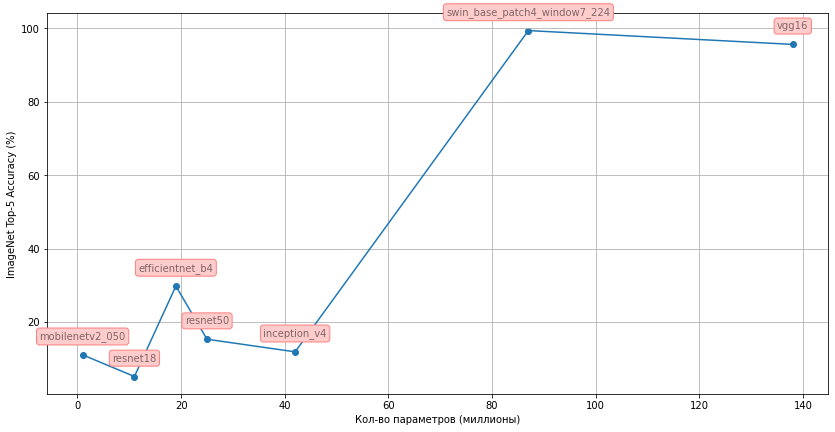

In [10]:
plot_model_stat(models_stats)

## Задание 2

Реализовать простенькую forward операцию свёртки, использовав утилиты из файла `im2col.py`

Что надо сделать:

1. Реализовать функцию forward следуя шаблону
2. Задать самостоятельно интересный фильтр, взять картинку любую (лучше из сети) и применить свою `forward` операцию на этой картинке с вашим фильтром (или несколькими, как вам угодно).

<img src="https://praisethemoon.org/wp-content/uploads/2019/03/giphy-1.gif" width=600 height=500/>

In [11]:
def forward(X, W, b, stride=1, padding=1):
    """
    X: DxCxHxW, где D - количество картинок на входе, C - каналы
    W: NFxCxHFxHW - фильтры, свернутые в одну матрицу,
        * NF - количество фильтров
        * C - то же C - количество каналов в картинке
        * HF, HW - высота и ширина фильтра
    b: Fx1 - параметр байеса
    
    Результат
    ---------
    forward_result : np.ndarray
      Результат свертки
      DxNFxHRxWR
        * HR - Высота выхода фильтра после свертки
        * WR - Ширина выхода фильтра после свертк
    """
    
    assert len(W.shape) == 4
    assert len(X.shape) == 4
    
    n_image, c_image, h_image, w_image = X.shape
    n_filter, c_filter, h_filter, w_filter = W.shape
    
    assert c_image == c_filter, "Кол-во каналов в фильтре должно совпадать с кол-вом каналов изображений"
    
    X_col = im2col_indices(X, h_filter, w_filter, padding=padding, stride=stride)
    
    # Ширина выхода фильтра после свертки
    filter_out_height = (h_image + 2 * padding - h_filter) // stride + 1
    # Высота выхода фильтра после свертки
    filter_out_width = (w_image + 2 * padding - w_filter) // stride + 1
    
    # Результирующий формат: (количество множителей окна свертки, кол-во фильтров)
    W = W.reshape((W.shape[0], -1)).T
    
    # Транспонируем X_col, чтобы в строках были значения окон сверток по каналам для одного изображения
    # окно 1 канал 1| окно 1 канал 2 | окно 1 канал 3 
    forward_result = (X_col.T @ W).T.reshape((n_image, n_filter, filter_out_height, filter_out_width))
    # Добавляем смещение
    forward_result += b
    
    return forward_result

##### Применим к изображению оператор Собеля

In [12]:
img = read_image("korella.jpg")[np.newaxis]

sobel_x = np.array([
    [
        [-1,-2,-1],
        [0,0,0],
        [1,2,1]
    ]
])
sobel_x = np.tile(sobel_x, (3, 1, 1))[np.newaxis]

sobel_y = np.array([
    [
        [-1,0,1],
        [-2,0,2],
        [-1,0,1]
    ]
])
sobel_y = np.tile(sobel_y, (3, 1, 1))[np.newaxis]

w_filter = np.concatenate([sobel_x, sobel_y], axis=0)

In [13]:
forward_result = forward(X=img, W=w_filter, b=0, stride=1, padding=0)

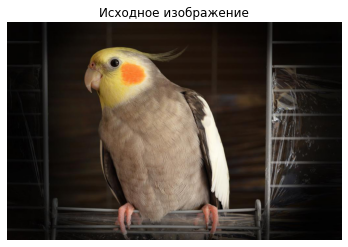

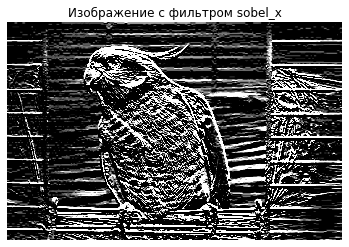

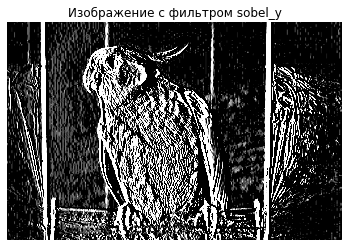

In [14]:
plt.imshow(img[0].moveaxis(0,2))
plt.title("Исходное изображение")
plt.axis('off')
plt.show()

for filter_name, sobel_filter_result in zip(('sobel_x', 'sobel_y'), forward_result[0]):
    plt.imshow(sobel_filter_result, cmap='gray', vmin=0, vmax=25)
    plt.title(f"Изображение с фильтром {filter_name}")
    plt.axis('off')
    plt.show()